In [2]:
import os
import pathlib
from pandas.core.common import flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision import models

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
class MyModel(nn.Module):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()

        # Define the layers of the network
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1
        )
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1
        )
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1
        )
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1
        )
        self.relu4 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc4 = nn.Linear(in_features=256 * 16 * 16, out_features=512)
        self.relu4 = nn.ReLU(inplace=True)

        self.fc5 = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        # Pass the input through the layers of the network
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        x = x.view(x.size(0), -1)
        x = self.fc4(x)
        x = self.relu4(x)

        x = self.fc5(x)

        return x

In [4]:
# Define the ResNet-based CNN model
class ResNetCNN(nn.Module):
    def __init__(self, num_classes):
        super(ResNetCNN, self).__init__()
        
        # Load the pre-trained ResNet-18 model
        resnet = models.resnet152(pretrained=True)
        
        # Remove the last fully connected layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        # Add a new fully connected layer
        self.fc = nn.Linear(resnet.fc.in_features, num_classes)

    def forward(self, x):
        # Pass the input through the ResNet model
        x = self.resnet(x)
        
        # Flatten the output tensor
        x = x.view(x.size(0), -1)
        
        # Pass the output through the fully connected layer
        x = self.fc(x)
        return x

In [5]:
for dirpath, dirnames, filenames in os.walk("Dataset"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

bean_class = len(os.listdir("Dataset/train"))

dataset_dir = pathlib.Path("Dataset/train")
class_names = np.array(sorted([item.name for item in dataset_dir.glob("*")]))
print(class_names)

There are 2 directories and 0 images in Dataset
There are 2 directories and 0 images in Dataset\test
There are 0 directories and 100 images in Dataset\test\Defected
There are 0 directories and 100 images in Dataset\test\Undefected
There are 2 directories and 0 images in Dataset\train
There are 0 directories and 400 images in Dataset\train\Defected
There are 0 directories and 400 images in Dataset\train\Undefected
['Defected' 'Undefected']


In [6]:
# train_defect_images = glob.glob("Dataset/train/Defected/*.jpg")
# train_undefect_images = glob.glob("Dataset/train/Undefected/*.jpg")

# train_concat = train_defect_images + train_undefect_images

# train_image_paths = list(flatten(train_concat))
# random.shuffle(train_image_paths)

# train_image_paths, test_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[:int(0.2*len(train_image_paths))]
# print(len(train_image_paths), len(test_image_paths))

In [7]:
# Define the hyperparameters and optimizer
num_epochs = 8
learning_rate = 0.001
batch_size = 8
num_classes = 2

# Own Model
model = MyModel(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 2: Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((256, 256)),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229,0.224,0.225)),
    ]
)

# Define the dataset
train_set = datasets.ImageFolder(root='Dataset/train/', transform=transform)

# Define a data loader to iterate over the dataset
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Define the dataset
test_set = datasets.ImageFolder(root='Dataset/test/', transform=transform)

# Define a data loader to iterate over the dataset
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [9]:
# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print('[Epoch %d, Batch %5d] loss: %.3f' %
                  (epoch+1, i+1, running_loss / 100))
            running_loss = 0.0
    
    correct = 0
    total = 0

    # Calculate training accuracy
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_acc = correct / total
    print('Training Accuracy: {:.2f}%'.format(train_acc * 100))

c:\Users\LnData User\Documents\TA GASS\Defect-Classification\.venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[Epoch 1, Batch   100] loss: 0.568
Training Accuracy: 88.25%
[Epoch 2, Batch   100] loss: 0.269
Training Accuracy: 95.12%
[Epoch 3, Batch   100] loss: 0.174
Training Accuracy: 96.88%
[Epoch 4, Batch   100] loss: 0.273
Training Accuracy: 97.12%
[Epoch 5, Batch   100] loss: 0.112
Training Accuracy: 98.50%
[Epoch 6, Batch   100] loss: 0.113
Training Accuracy: 98.00%
[Epoch 7, Batch   100] loss: 0.057
Training Accuracy: 94.88%
[Epoch 8, Batch   100] loss: 0.051
Training Accuracy: 99.88%


In [10]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    predictions = []
    ground_truths = []
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        predictions.extend(predicted.numpy())
        ground_truths.extend(labels.numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print('Validating Accuracy: {:.2f}%'.format(test_acc * 100))

Testing Accuracy: 100.00%


<Axes: >

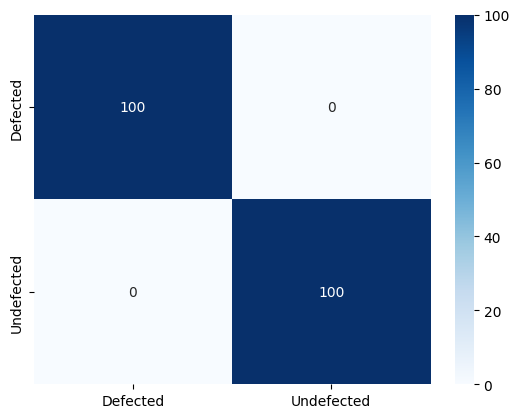

In [11]:
# Calculate the confusion matrix
cm = confusion_matrix(ground_truths, predictions)
labels_category = ['Defected', 'Undefected']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels= labels_category, yticklabels=labels_category)

In [12]:
model = ResNetCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

c:\Users\LnData User\Documents\TA GASS\Defect-Classification\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LnData User\Documents\TA GASS\Defect-Classification\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to C:\Users\LnData User/.cache\torch\hub\checkpoints\resnet152-394f9c45.pth
100.0%


In [13]:
# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print('[Epoch %d, Batch %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

    # Calculate training accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_acc = correct / total
    print('Training Accuracy: {:.2f}%'.format(train_acc * 100))

c:\Users\LnData User\Documents\TA GASS\Defect-Classification\.venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training Accuracy: 89.12%


KeyboardInterrupt: 

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    predictions = []
    ground_truths = []
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        predictions.extend(predicted.numpy())
        ground_truths.extend(labels.numpy())

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print('Testing Accuracy: {:.2f}%'.format(test_acc * 100))

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(ground_truths, predictions)
labels_category = ['Defected', 'Undefected']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels= labels_category, yticklabels=labels_category)